In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2022/train.csv
/kaggle/input/tabular-playground-series-feb-2022/test.csv


In [2]:
import gc
import random

from IPython import display as ipd
from tqdm import tqdm
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

### Utils

In [3]:
def seeding(SEED, use_tf=False):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    if use_tf:
        tf.random.set_seed(SEED)
    print('seeding done!!!')

### Data load

In [4]:
RANDOM_SEED = 42
DEBUG = True
seeding(RANDOM_SEED)

train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')

seeding done!!!


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 288 entries, row_id to target
dtypes: float64(286), int64(1), object(1)
memory usage: 439.5+ MB


In [6]:
## display missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
row_id,0,0.0
A0T0G0C10,0,0.0
A3T4G3C0,0,0.0
A3T4G2C1,0,0.0
A3T4G1C2,0,0.0
A3T4G0C3,0,0.0
A3T3G4C0,0,0.0
A3T3G3C1,0,0.0
A3T3G2C2,0,0.0
A3T3G1C3,0,0.0


### Encode target

In [7]:
target = train.target
train.drop(['target'], axis=1, inplace=True) 

In [8]:
encoder = LabelEncoder()
target = pd.DataFrame(encoder.fit_transform(target), columns=['target'])
target = target.astype(int)

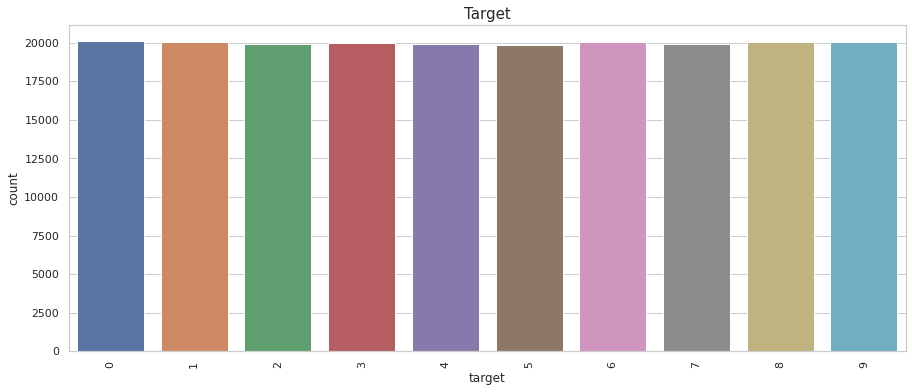

In [9]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.countplot(x='target', data=target)
plt.title('Target', fontsize=15)
plt.show()

### Getting more info about features after EDA:

https://www.kaggle.com/vladlee/tps-feb-2022-simple-eda

just wait for it, loading takes time :)

In [10]:
train_skewed_cols = ['A0T0G0C10','A0T0G1C9','A0T0G2C8','A0T0G8C2','A0T0G9C1','A0T0G10C0','A0T1G1C8','A0T1G8C1','A0T1G9C0','A0T2G0C8',
    'A0T2G8C0','A0T3G0C7','A0T3G7C0','A0T10G0C0','A1T0G0C9','A1T0G8C1','A1T0G9C0','A1T1G0C8','A1T1G8C0','A2T0G0C8','A2T0G8C0',
    'A2T1G0C7','A3T0G0C7','A3T0G7C0','A10T0G0C0']

train_categorical_cols = ['A0T0G9C1', 'A0T0G10C0', 'A0T1G0C9', 'A0T1G9C0', 'A0T2G0C8', 'A0T2G8C0', 'A0T10G0C0', 'A1T0G0C9', 'A1T0G9C0',
    'A1T1G8C0','A2T0G0C8','A2T0G8C0','A10T0G0C0']

test_skewed_cols = ['A0T0G0C10','A0T0G1C9','A0T0G2C8','A0T0G8C2','A0T0G9C1','A0T0G10C0','A0T1G1C8','A0T1G8C1',
    'A0T1G9C0','A0T2G0C8','A0T2G1C7','A0T2G8C0','A0T3G0C7','A0T3G7C0','A0T9G1C0','A1T0G0C9',
    'A1T0G8C1','A1T0G9C0','A1T1G0C8','A2T0G0C8','A2T0G8C0','A3T0G0C7','A3T0G7C0','A9T0G0C1','A10T0G0C0']

test_categorical_cols = [ 'A0T0G0C10','A0T0G1C9','A0T0G9C1','A0T0G10C0','A0T1G0C9','A0T1G9C0','A0T10G0C0',
    'A1T0G0C9','A1T0G9C0','A10T0G0C0']

In [11]:
skewed_cols = []
categorical_cols = []

for col in train_skewed_cols:
    if col not in skewed_cols:
        skewed_cols.append(col)

for col in test_skewed_cols:
    if col not in skewed_cols:
        skewed_cols.append(col)
        
for col in train_categorical_cols:
    if col not in categorical_cols:
        categorical_cols.append(col)

for col in test_categorical_cols:
    if col not in categorical_cols:
        categorical_cols.append(col)        
        
print(skewed_cols)
print()
print(categorical_cols)

['A0T0G0C10', 'A0T0G1C9', 'A0T0G2C8', 'A0T0G8C2', 'A0T0G9C1', 'A0T0G10C0', 'A0T1G1C8', 'A0T1G8C1', 'A0T1G9C0', 'A0T2G0C8', 'A0T2G8C0', 'A0T3G0C7', 'A0T3G7C0', 'A0T10G0C0', 'A1T0G0C9', 'A1T0G8C1', 'A1T0G9C0', 'A1T1G0C8', 'A1T1G8C0', 'A2T0G0C8', 'A2T0G8C0', 'A2T1G0C7', 'A3T0G0C7', 'A3T0G7C0', 'A10T0G0C0', 'A0T2G1C7', 'A0T9G1C0', 'A9T0G0C1']

['A0T0G9C1', 'A0T0G10C0', 'A0T1G0C9', 'A0T1G9C0', 'A0T2G0C8', 'A0T2G8C0', 'A0T10G0C0', 'A1T0G0C9', 'A1T0G9C0', 'A1T1G8C0', 'A2T0G0C8', 'A2T0G8C0', 'A10T0G0C0', 'A0T0G0C10', 'A0T0G1C9']


In [12]:
train[skewed_cols] = train[skewed_cols]**2
test[skewed_cols] = test[skewed_cols]**2

## removing hegatives
train[categorical_cols] = train[categorical_cols]**2
test[categorical_cols] = test[categorical_cols]**2

In [13]:
train.drop( ['row_id'], axis=1, inplace=True)
test.drop( ['row_id'], axis=1, inplace=True)

In [14]:
## doublecheck

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
A0T0G0C10,0,0.0
A3T3G1C3,0,0.0
A3T4G2C1,0,0.0
A3T4G1C2,0,0.0
A3T4G0C3,0,0.0
A3T3G4C0,0,0.0
A3T3G3C1,0,0.0
A3T3G2C2,0,0.0
A3T3G0C4,0,0.0
A3T5G0C2,0,0.0


### Model

In [15]:
TOTAL_SPLITS = 10
N_REPEATS = 1
NUM_BOOST_ROUND = 100
EARLY_STOPPING_ROUNDS = 50
VERBOSE_EVAL = 100

def run_train(X, y, run_params, splits, num_boost_round, verbose_eval, early_stopping_rounds ):
    scores = []
    models = []
    y_preds = []
    eval_results = {}  # to record eval results for plotting
    folds = StratifiedKFold(n_splits=splits)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print(f'Fold {fold_n+1} started')
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.train(
            run_params, valid_names=["train", "valid"], 
            categorical_feature = categorical_cols,
            train_set=lgb.Dataset(X_train, y_train ), 
            num_boost_round = num_boost_round,
            valid_sets = [lgb.Dataset(X_valid, y_valid)],
            callbacks=[lgb.log_evaluation(verbose_eval), 
               lgb.early_stopping(early_stopping_rounds, False, True),
               lgb.record_evaluation(eval_result=eval_results)],
        )

        y_pred = np.round(model.predict(X_valid)).astype(int)
        y_hat = y_pred.argmax(axis = 1)
        
        score = accuracy_score(y_valid, y_hat)
        print(f'Accuracy score: {score}')        
        
        y_preds.append(y_hat)
        models.append(model)
        scores.append(score)
    return scores, models, y_preds


run_params = {
    'verbosity': -1,
    'num_class' : 10,
    'boosting_type': 'gbdt', 
    'objective': 'multiclass', 
    'metric': ['multi_logloss', 'multi_error'],
    'force_col_wise' : True,
    'eta': 0.13,
}


scores, models, y_preds = run_train(train, target, run_params, 
                    TOTAL_SPLITS, NUM_BOOST_ROUND, VERBOSE_EVAL, EARLY_STOPPING_ROUNDS)

Fold 1 started
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.0930881	train's multi_error: 0.01405
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.0930881	train's multi_error: 0.01405
Accuracy score: 0.96785
Fold 2 started
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.0975865	train's multi_error: 0.015
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.0975865	train's multi_error: 0.015
Accuracy score: 0.9639
Fold 3 started
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.0949118	train's multi_error: 0.0128
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.0949118	train's multi_error: 0.0128
Accuracy score: 0.96675
Fold 4 started
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.0948545	train's multi_error: 0.01345
Did not mee

### Classification Report

In [16]:
for model in models:
    y_pred = model.predict(train)
    print(classification_report(target, y_pred.argmax(axis = 1), target_names=encoder.classes_))

                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.99      0.99      0.99     20139
    Campylobacter_jejuni       1.00      1.00      1.00     20063
      Enterococcus_hirae       0.99      0.99      0.99     19947
        Escherichia_coli       0.99      0.99      0.99     19958
  Escherichia_fergusonii       0.99      0.99      0.99     19937
   Klebsiella_pneumoniae       1.00      1.00      1.00     19847
     Salmonella_enterica       0.99      0.99      0.99     20030
   Staphylococcus_aureus       0.99      1.00      1.00     19929
Streptococcus_pneumoniae       0.99      0.99      0.99     20074
  Streptococcus_pyogenes       0.99      0.99      0.99     20076

                accuracy                           0.99    200000
               macro avg       0.99      0.99      0.99    200000
            weighted avg       0.99      0.99      0.99    200000

                          precision    recall  f1-score   support

    Ba

### Submit

In [17]:
predicted = []
for model in models:
    y_pred = model.predict(test)
    predicted.append(y_pred.argmax(axis = 1))
    
test_pred = np.mean(predicted, axis=0).astype(int)   

In [18]:
submission['target'] = encoder.inverse_transform(test_pred)
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus
5,200005,Escherichia_fergusonii
6,200006,Salmonella_enterica
7,200007,Staphylococcus_aureus
8,200008,Streptococcus_pneumoniae
9,200009,Klebsiella_pneumoniae
